# Aim to measure the surface brightness within a epanda region generate by ds9 to plot the radial profile. Crossmatch with the contour which is 1-sigma above the backgourd level.

In [4]:
from astropy.io import fits
import matplotlib.pyplot as plt
import sys
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.nddata import Cutout2D
import numpy as np
from astropy.visualization import ZScaleInterval
from astropy.visualization import ImageNormalize
from scipy.stats import norm
from scipy import ndimage

In [2]:
sys.path.append('/home/lupengjun/OII_emitter/photometry/code')
import multibandphotometry as mbp
from fit_gaussian import gaussian_2D

## Get the 1-sigma above backgound value, using nebula fits and source mask.

In [20]:
OII_nebula = fits.getdata('../../output/nebula_fits/OII_nebula.fits')
OIII_nebula = fits.getdata('../../output/nebula_fits/OIII_nebula.fits')

In [21]:
source_position = SkyCoord(150.15949, 2.1914772, frame='icrs', unit=u.deg)
z = 0.924
phot = mbp.MultiBandPhotometry(source_position, z,)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2016-06-04T00:47:19.488' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:37:16.477' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-06-29T23:52:46.677' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-05-03T03:02:47.823' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2016-04-30T03:11:04.794' from MJD-END'. [astropy.wcs.wcs]


In [22]:
bkg_map, rms_map, source_mask = phot.load_background('SUBARU_NB0718')
source_mask_cutout = Cutout2D(source_mask, source_position, size=10*u.arcsec, wcs=phot.wcss['SUBARU_NB0718'])

In [23]:
masked_nebula = np.ma.array(OII_nebula, mask=source_mask_cutout.data)
masked_nebula_1D = masked_nebula.data.flatten()[~masked_nebula.mask.flatten()]

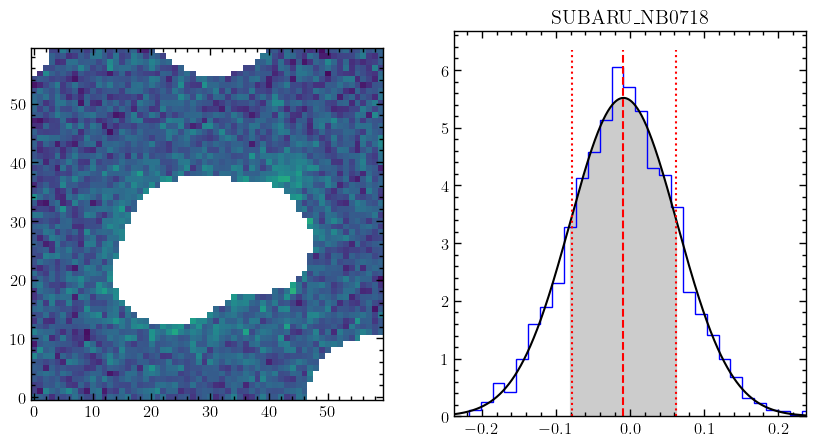

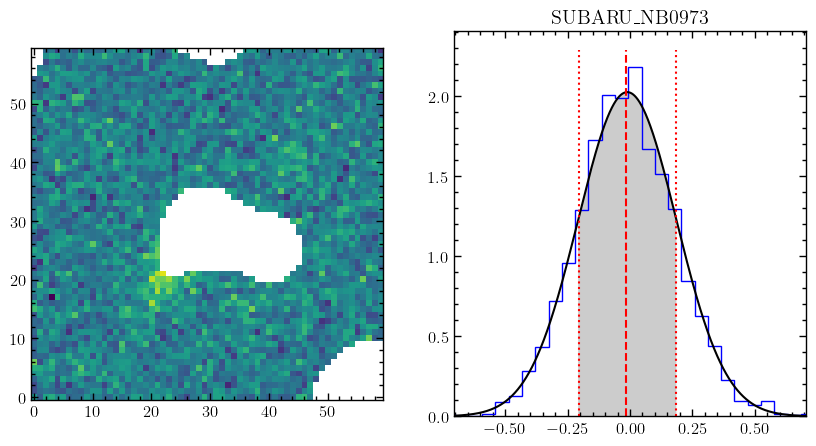

In [24]:
bkg_upsigmas = []
for telescope_band, nebula in zip(['SUBARU_NB0718', 'SUBARU_NB0973'], [OII_nebula, OIII_nebula]):
    bkg_map, rms_map, source_mask = phot.load_background(telescope_band)
    source_mask_cutout = Cutout2D(source_mask, source_position, size=10*u.arcsec, wcs=phot.wcss[telescope_band])
    masked_nebula = np.ma.array(nebula, mask=source_mask_cutout.data)
    masked_nebula_1D = masked_nebula.data.flatten()[~masked_nebula.mask.flatten()]
    mu, std = norm.fit(masked_nebula_1D)
    nm = ImageNormalize(masked_nebula, interval=ZScaleInterval())
    plt.figure(figsize=(10, 5))
    plt.subplot(1,2,1)
    plt.imshow(masked_nebula, origin='lower', norm=nm)
    plt.subplot(1,2,2)
    plt.hist(masked_nebula_1D, bins=30, edgecolor='blue', histtype='step', density=True)
    xlim0 = np.abs([np.percentile(masked_nebula_1D, 0.1), np.percentile(masked_nebula_1D, 99.9)]).max()
    plt.xlim(-xlim0, xlim0)
    ymin, ymax = plt.ylim()
    x = np.linspace(-xlim0, xlim0, 10000) 
    p = norm.pdf(x, mu, std) 
    plt.plot(x, p, 'k') 
    plt.vlines([np.median(masked_nebula_1D)], [ymin], [ymax], color='red', linestyle='dashed')
    plt.vlines([np.percentile(masked_nebula_1D, 16), np.percentile(masked_nebula_1D, 84)], ymin, ymax, color='red', linestyle='dotted') # 1 sigma
    plt.fill_between(x, p, where=((x>(mu-std))&(x<(mu+std))), facecolor='k', alpha=0.2)
    plt.title(telescope_band)
    plt.show()
    bkg_upsigmas.append(mu+std)

In [25]:
bkg_upsigmas

[0.06356433, 0.18596862]

## Plot contour using these values and make masks

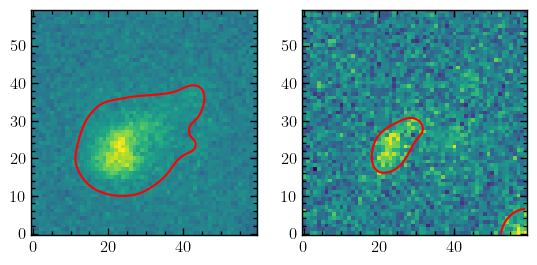

In [26]:
contour_list = []
nm = ImageNormalize(OIII_nebula, interval=ZScaleInterval())
for i, nebula in enumerate([OII_nebula, OIII_nebula]):
    plt.subplot(1,2,i+1)
    nebula_smoothed = ndimage.gaussian_filter(nebula, sigma=3)
    # nm = ImageNormalize(nebula, interval=ZScaleInterval())
    plt.imshow(nebula, origin='lower', norm=nm)
    contour = plt.contour(nebula_smoothed, levels=[bkg_upsigmas[i]], colors='red')
    # plt.show()
    contour_list.append(contour)

In [27]:
def create_mask_from_path(path, shape):
    mask = np.zeros(shape, dtype=bool)
    for i in range(shape[0]):
        for j in range(shape[1]):
            mask[i, j] = path.contains_point([j, i])
    return mask

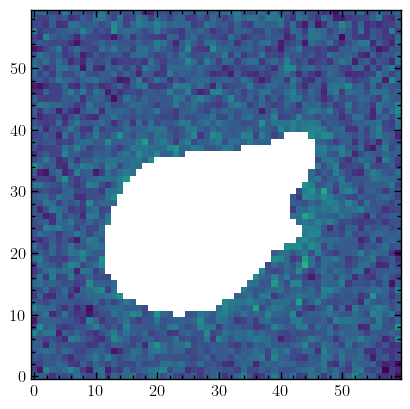

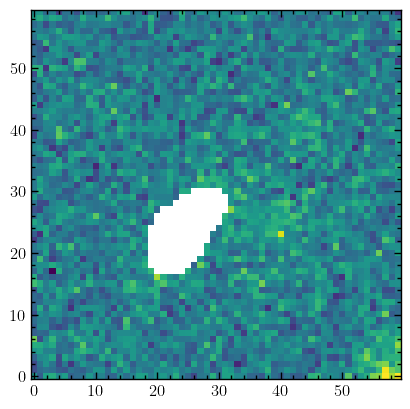

In [28]:
nebula_masks = []
for nebula, contours in zip([OII_nebula, OIII_nebula], contour_list):
    path = contours.collections[0].get_paths()[-1] #choose the nebula contour path
    mask = create_mask_from_path(path, nebula.shape)
    masked_nebula = np.ma.array(nebula, mask=mask)
    nm = ImageNormalize(nebula, interval=ZScaleInterval())
    plt.imshow(masked_nebula, origin='lower', norm=nm)
    plt.show()
    nebula_masks.append(mask)

## Read epanda region from ds9 using pyregion and get the crossmatch masks

In [1]:
import pyregion

In [2]:
masks = []
for i in range(1, 6):
    region = pyregion.open(f'pandas_suit_series/pandas_suit{i}.reg')
    mask = region.get_mask(shape=(60,60))
    masks.append(mask)

In [32]:
pandas = pyregion.open('pandas_suit.reg')
patch_list, artist_list = pandas.get_mpl_patches_texts()

In [21]:
patch_list

In [5]:
combined_masks = np.zeros((60,60), dtype=int)
for i, mask in enumerate(masks, start=1):
    combined_masks[mask] = i

In [7]:
combined_masks.max()

5

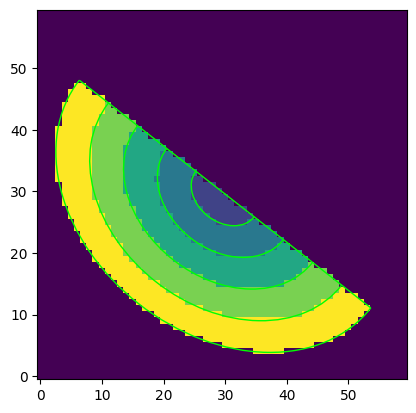

In [33]:
from copy import copy
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(combined_masks, origin='lower')
for p in patch_list:
    new_p = copy(p)
    ax.add_patch(new_p)

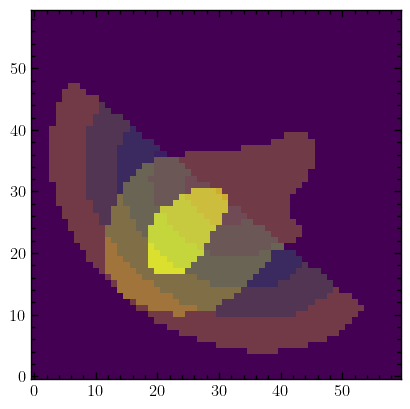

In [46]:
plt.imshow(combined_masks, origin='lower')
plt.imshow(nebula_masks[0], origin='lower', alpha=0.5)
plt.imshow(nebula_masks[1], origin='lower', alpha=0.5)

In [47]:
annulus_masks = {'OII':[], 'OIII':[]}
for i in range(1,6):
    annulus_masks['OII'].append((combined_masks==i)&(nebula_masks[0]))
    annulus_masks['OIII'].append((combined_masks==i)&(nebula_masks[1]))

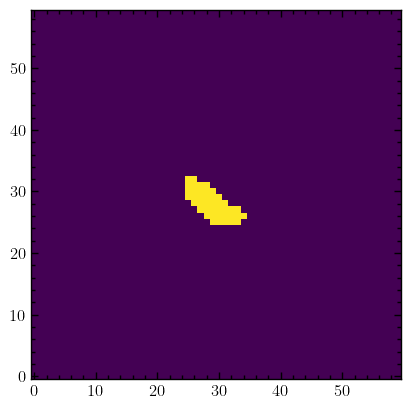

In [48]:
plt.imshow(annulus_masks['OII'][0], origin='lower')

In [7]:
def int_filter_curve(file):
    '''
    Read the filter curve file and return the integral of the filter curve.
    '''
    data = np.loadtxt(file, unpack=True) #wavelength in angstrom
    frequencies = 3e18/data[0] #Hz
    return np.trapz(data[1][::-1], frequencies[::-1])

In [6]:
tr = np.arange(10)
tr[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [8]:
int_filter_curve('/home/lupengjun/OII_emitter/data/filter/SUBARU/Subaru_HSC.NB0718_filter.dat')

5728292798745.829

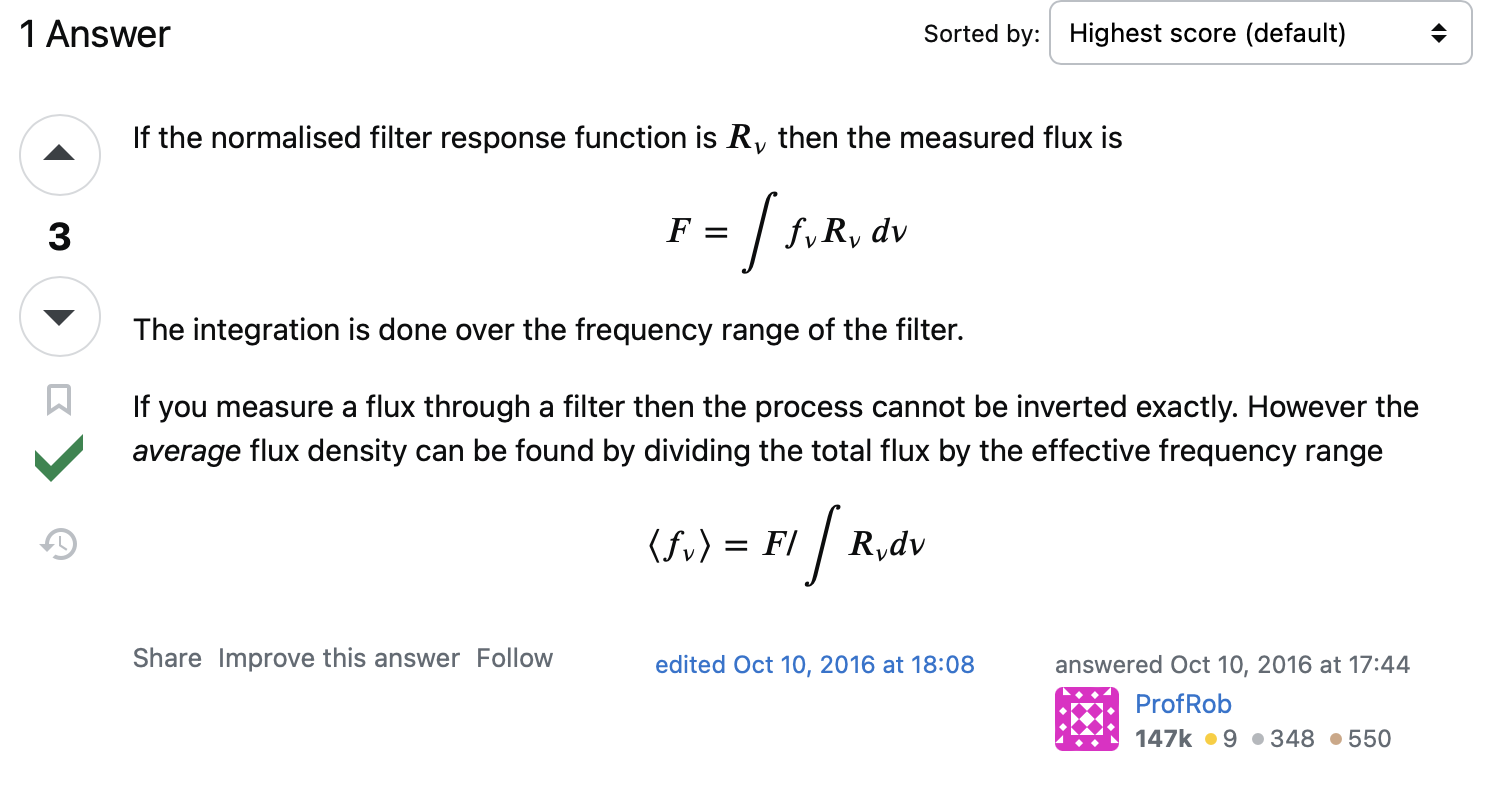

In [49]:
def calc_surface_brightness(nebula, mask, wcs):
    flux_sum = np.sum(nebula[mask])*10**(6-(27-8.9)/2.5) #zeropoint 27 to microJy
    area = np.sum(mask)*wcs.proj_plane_pixel_scales()[0].to(u.arcsec).value*wcs.proj_plane_pixel_scales()[1].to(u.arcsec).value #arcsec^2
    return flux_sum/area #microJy/arcsec^2

In [50]:
radial_profiles = {'OII':[], 'OIII':[]}
for name, band, nebula in zip(['OII', 'OIII'], ['SUBARU_NB0718', 'SUBARU_NB0973'], [OII_nebula, OIII_nebula]):
    for mask in annulus_masks[name]:
        radial_profiles[name].append(calc_surface_brightness(nebula, mask, phot.wcss[band]))

/tmp/ipykernel_860540/818398934.py:4: RuntimeWarning: invalid value encountered in scalar divide
  return flux_sum/area #microJy/arcsec^2


In [51]:
len(annulus_masks[name])

5

In [7]:
wcs = phot.wcss['SUBARU_NB0973']
wcs.proj_plane_pixel_scales()[0].to(u.arcsec).value, wcs.proj_plane_pixel_scales()[1].to(u.arcsec).value

(0.1679999999999004, 0.1679999999999004)

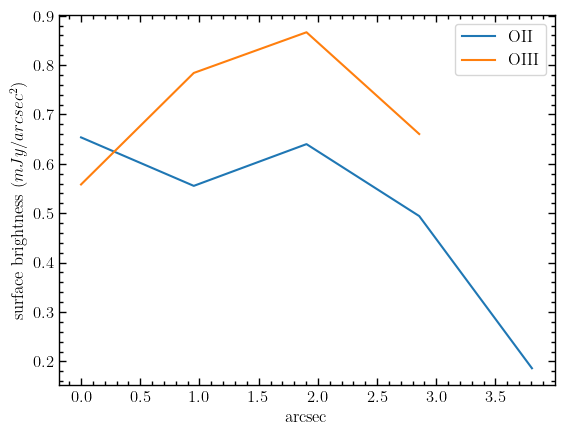

In [53]:
radius = np.linspace(0, 22.667181*0.168, 5)
plt.plot(radius, radial_profiles['OII'], label='OII')
plt.plot(radius, radial_profiles['OIII'], label='OIII')
plt.xlabel('arcsec')
plt.ylabel('surface brightness ($mJy/arcsec^2$)')
plt.legend()
plt.show()

In [24]:
np.sum(OII_nebula[nebula_masks[0]])*10**(6-(27-8.9)/2.5), np.sum(OIII_nebula[nebula_masks[1]])*10**(6-(27-8.9)/2.5)

(8.663582969904523, 2.6317146615076075)

# Estimate the psf fwhm to get a proper bin size

In [3]:
psf_OII = fits.getdata('../../output/psf_for_pypher/SUBARU_NB0718_PSFEx_psf.fits').astype(np.float64)
psf_OIII = fits.getdata('../../output/psf_for_pypher/SUBARU_NB0973_PSFEx_psf.fits').astype(np.float64)

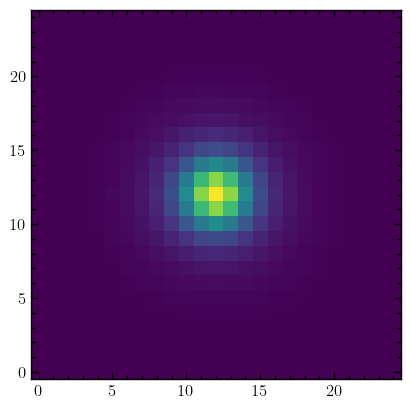

In [4]:
plt.imshow(psf_OII, origin='lower')

In [12]:
psf_OII.max(), psf_OIII.max(), psf_OII.min(), psf_OIII.min()

(0.04102587778090267, 0.0474213047552711, 0.0, 0.0)

In [10]:
g1 = gaussian_2D(psf_OII, (12, True), (12, True), (4, False), (4, False), (psf_OII.max(), True))
g2 = gaussian_2D(psf_OIII, (12, True), (12, True), (4, False), (4, False), (psf_OIII.max(), True))

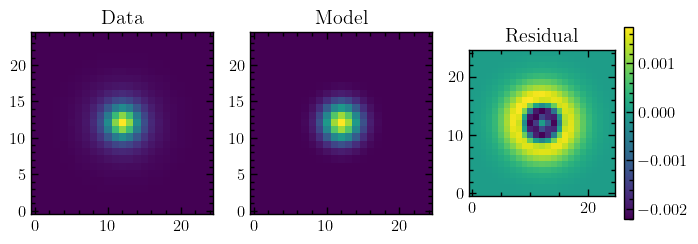

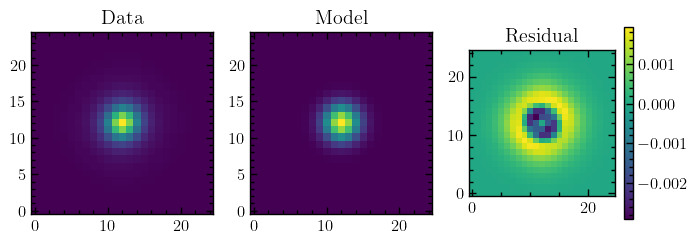

In [11]:
g1.plot_fitting_result()
g2.plot_fitting_result()

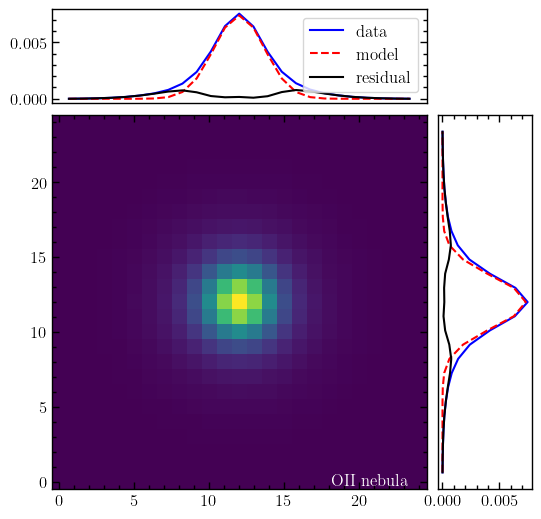

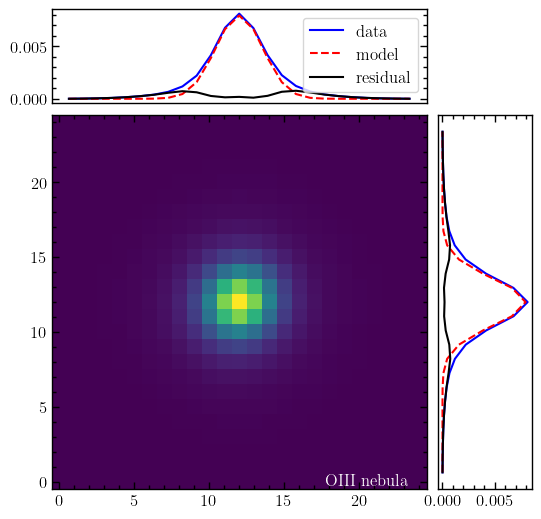

In [12]:
g1.plot_img_profile(name='OII nebula')
g2.plot_img_profile(name='OIII nebula')

In [17]:
g1.get_fwhm(g1.result_model.x_stddev.value), g2.get_fwhm(g2.result_model.x_stddev.value), g1.get_fwhm(g1.result_model.y_stddev.value), g2.get_fwhm(g2.result_model.y_stddev.value)

(4.220495691910532, 3.924628756677321, 4.206264758806013, 3.93580551566726)

Use 4 pixels as the annulus width, finally choose 5 annulus

# Try the python code

In [35]:
import sys
sys.path.append('..')
from nebula import nebula

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


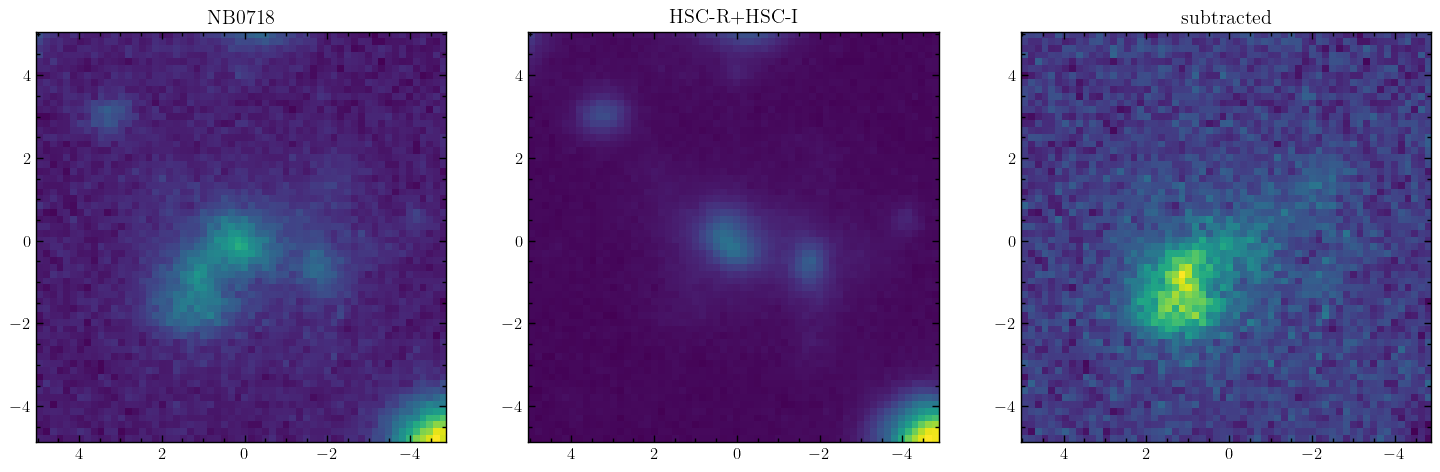

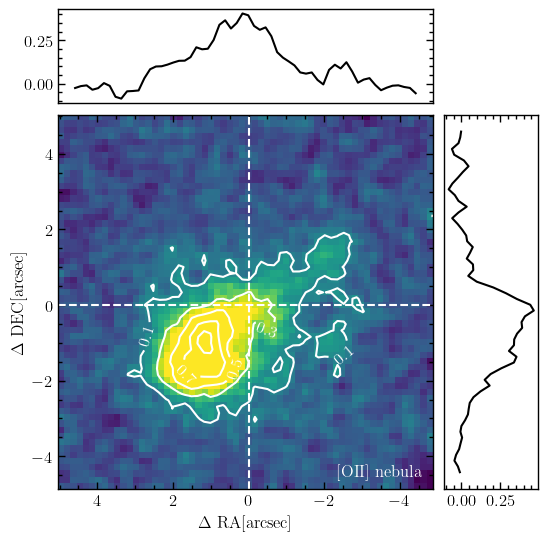

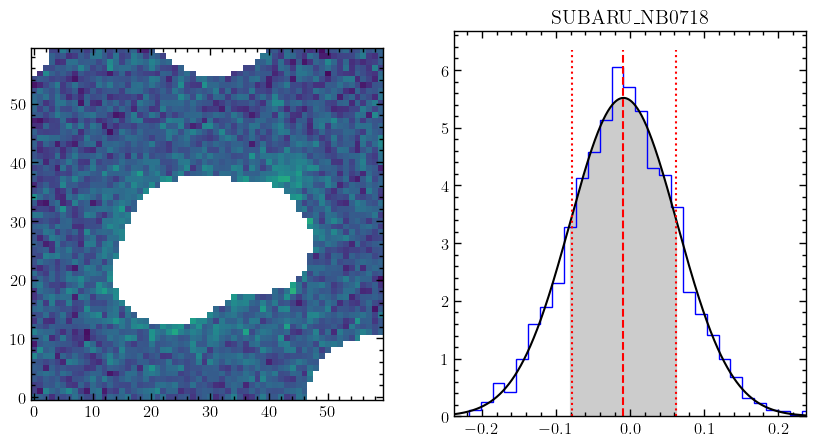

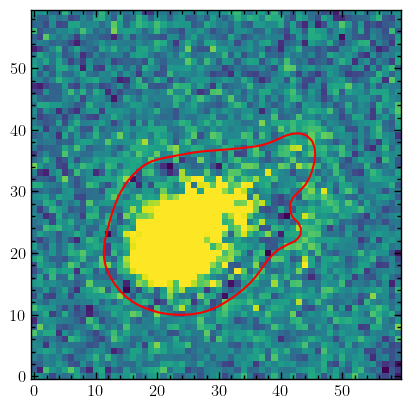

In [36]:
OII_nebula = nebula(name='OII', size=10*u.arcsec)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


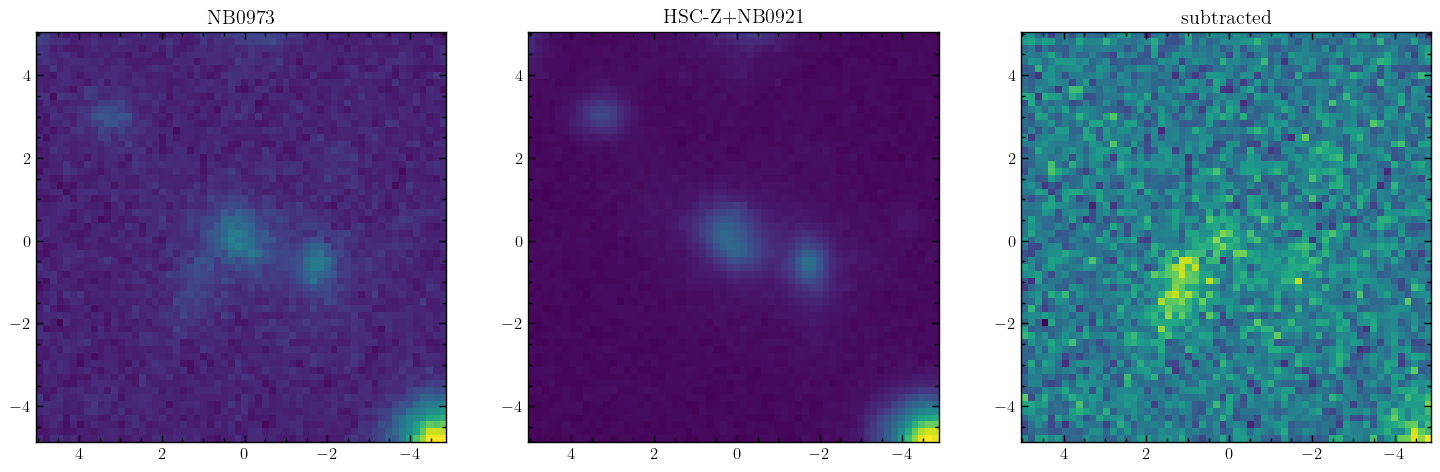

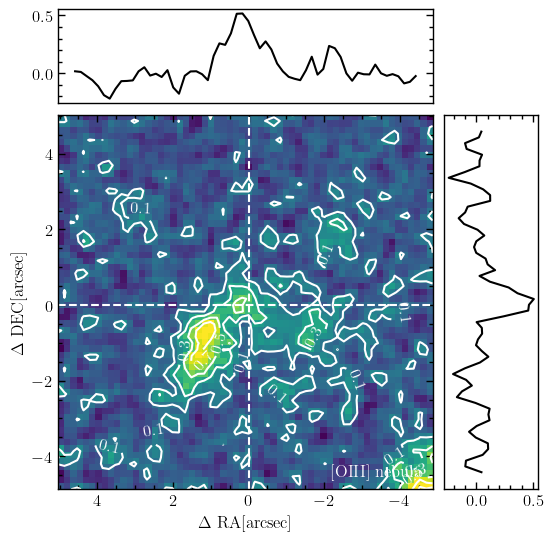

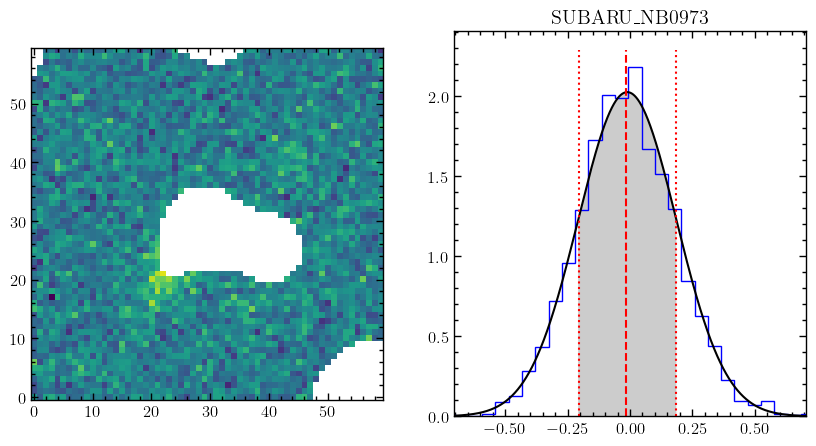

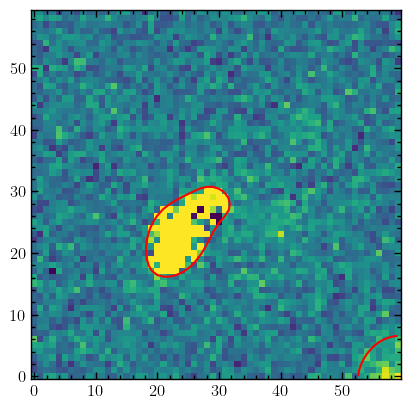

In [37]:
OIII_nebula = nebula(name='OIII', size=10*u.arcsec)

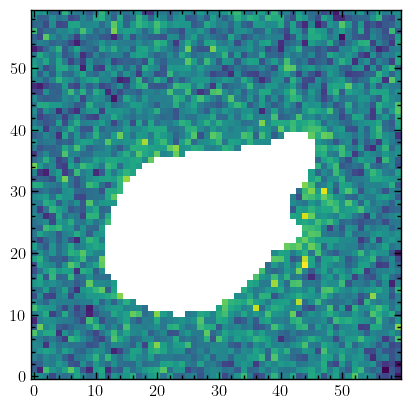

In [39]:
mask = OII_nebula.contour_mask
masked_nebula = np.ma.array(OII_nebula.data, mask=mask)
plt.imshow(masked_nebula, origin='lower')

In [10]:
np.abs(rms1)

array([[2.68839739, 2.52715511, 2.66616105, 2.41230015, 1.53069998],
       [2.48852299, 2.29156404, 2.46173626, 2.14694678, 0.80308754]])

/home/lupengjun/OII_emitter/photometry/code/nebula.py:26: RuntimeWarning: invalid value encountered in scalar divide
  return flux_sum/area
/home/lupengjun/OII_emitter/photometry/code/nebula.py:26: RuntimeWarning: invalid value encountered in scalar divide
  return flux_sum/area


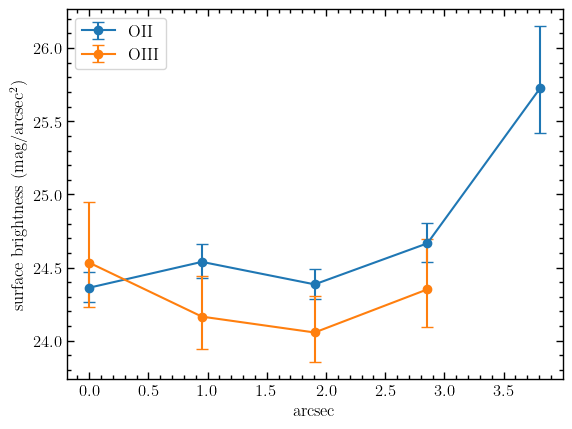

In [11]:
radius1, surface_brightness1, rms1 = OII_nebula.radial_profile(mode='mag')
radius2, surface_brightness2, rms2 = OIII_nebula.radial_profile(mode='mag')
plt.errorbar(radius1, surface_brightness1, rms1, fmt='-o', label='OII', capsize=4)
plt.errorbar(radius2, surface_brightness2, rms2, fmt='-o', label='OIII', capsize=4)
plt.legend()
plt.xlabel('arcsec')
plt.ylabel('surface brightness ($\\rm{mag/arcsec^2}$)')
plt.show()

/home/lupengjun/OII_emitter/photometry/code/nebula.py:26: RuntimeWarning: invalid value encountered in scalar divide
  return flux_sum/area
/home/lupengjun/OII_emitter/photometry/code/nebula.py:26: RuntimeWarning: invalid value encountered in scalar divide
  return flux_sum/area


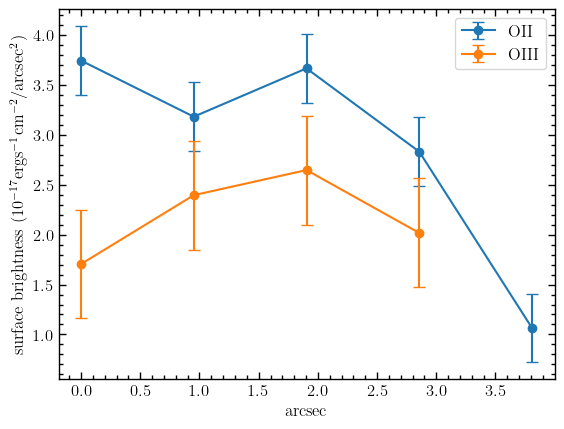

In [13]:
radius3, surface_brightness3, rms3 = OII_nebula.radial_profile(mode='flux')
radius4, surface_brightness4, rms4 = OIII_nebula.radial_profile(mode='flux')
plt.errorbar(radius3, surface_brightness3, rms3, fmt='-o', label='OII', capsize=4)
plt.errorbar(radius4, surface_brightness4, rms4, fmt='-o', label='OIII', capsize=4)
plt.legend()
plt.xlabel('arcsec')
plt.ylabel('surface brightness ($\\rm{10^{-17}ergs^{-1}cm^{-2}/arcsec^2}$)')
plt.show()

# Make RGB image with nebula contours and pandas contous, OII is red and OIII is blue.

In [63]:
OII_nebula.smoothed

array([[-0.02921581, -0.0281633 , -0.0264231 , ..., -0.08424768,
        -0.09550571, -0.10155573],
       [-0.02842613, -0.0275301 , -0.02606863, ..., -0.08143514,
        -0.09208959, -0.09780408],
       [-0.02686529, -0.02627137, -0.02534478, ..., -0.07584154,
        -0.08537022, -0.09046038],
       ...,
       [-0.03620236, -0.03614321, -0.03597832, ..., -0.04292081,
        -0.04197486, -0.04136364],
       [-0.03479942, -0.03486302, -0.03485975, ..., -0.04148424,
        -0.04050492, -0.03990833],
       [-0.03389062, -0.03402988, -0.0341313 , ..., -0.04053802,
        -0.03953052, -0.03893777]], dtype=float32)

In [83]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

[]

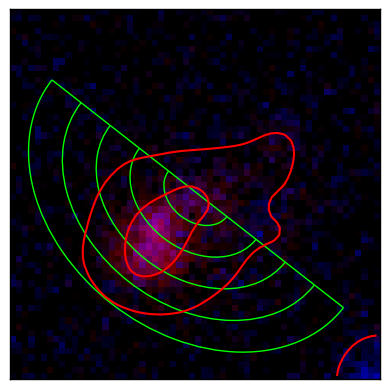

In [85]:
from astropy.visualization import ZScaleInterval, ImageNormalize, make_lupton_rgb
from copy import copy
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.imshow(combined_masks, origin='lower')

image_r = OII_nebula.data
image_b = OIII_nebula.data
image_g = np.zeros_like(image_r)
rgb_img = make_lupton_rgb(image_r, image_g, image_b, stretch=1.5, Q=0.1)
ax.imshow(rgb_img, origin='lower')
for p in patch_list:
    new_p = copy(p)
    ax.add_patch(new_p)
ax.contour(OII_nebula.smoothed, levels=[OII_nebula.threshold], colors='red')
ax.contour(OIII_nebula.smoothed, levels=[OIII_nebula.threshold], colors='red')
ax.set_xticks([])
ax.set_yticks([])

In [81]:
CS.collections[0].get_paths()[-1]

Path(array([[20.        , 16.44052237],
       [21.        , 16.17266817],
       [22.        , 16.19352745],
       [23.        , 16.42077873],
       [24.        , 16.85030865],
       [24.23773788, 17.        ],
       [25.        , 17.51712008],
       [25.54029113, 18.        ],
       [26.        , 18.46568154],
       [26.46176587, 19.        ],
       [27.        , 19.74029128],
       [27.18863746, 20.        ],
       [27.79178982, 21.        ],
       [28.        , 21.42439466],
       [28.33144659, 22.        ],
       [28.83044321, 23.        ],
       [29.        , 23.3649584 ],
       [29.41144334, 24.        ],
       [30.        , 24.89513193],
       [30.10052552, 25.        ],
       [30.94385135, 26.        ],
       [31.        , 26.09212639],
       [31.59522185, 27.        ],
       [31.77188126, 28.        ],
       [31.50335339, 29.        ],
       [31.        , 29.67883605],
       [30.69723677, 30.        ],
       [30.        , 30.4333971 ],
       [29.    

TypeError: 'Path' object is not subscriptable

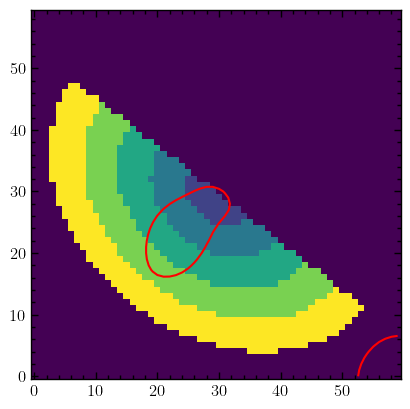

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(combined_masks, origin='lower')
CS = ax.contour(OIII_nebula.smoothed, levels=[OIII_nebula.threshold], colors='red')
for i, contour_path in enumerate(CS.collections[0].get_paths()):
    # Assuming you want to convert the first contour
    path_patch = PathPatch(contour_path[0], facecolor='none', edgecolor='red')
    ax.add_patch(path_patch)

In [82]:
dir(contour_path)

['CLOSEPOLY',
 'CURVE3',
 'CURVE4',
 'LINETO',
 'MOVETO',
 'NUM_VERTICES_FOR_CODE',
 'STOP',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_codes',
 '_create_closed',
 '_fast_from_codes_and_verts',
 '_interpolation_steps',
 '_readonly',
 '_should_simplify',
 '_simplify_threshold',
 '_unit_circle',
 '_unit_circle_righthalf',
 '_unit_rectangle',
 '_unit_regular_polygons',
 '_unit_regular_stars',
 '_update_values',
 '_vertices',
 'arc',
 'circle',
 'cleaned',
 'clip_to_bbox',
 'code_type',
 'codes',
 'contains_path',
 'contains_point',
 'contains_points',
 'copy',
 'deepcopy',
 'get_extents',
 'hatch',
 'interpolated',
 'i

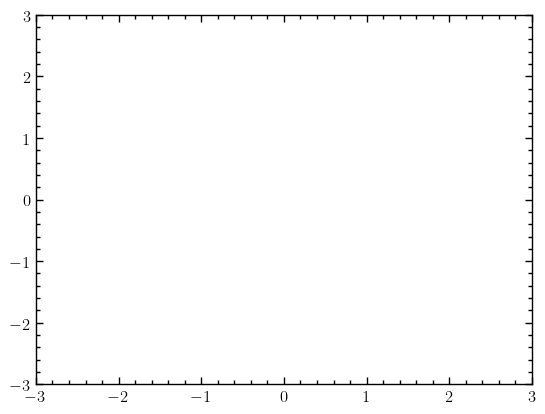

In [69]:
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from matplotlib.path import Path
import numpy as np

# Create some data to contour
x = np.linspace(-3.0, 3.0, 100)
y = np.linspace(-3.0, 3.0, 100)
X, Y = np.meshgrid(x, y)
Z = np.exp(-2 * (X**2 + Y**2))

# Create a contour plot
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)

# Convert the first contour to a patch
for i, contour_path in enumerate(CS.collections[0].get_paths()):
    # Assuming you want to convert the first contour
    path_patch = PathPatch(contour_path, facecolor='none', edgecolor='black')
    ax.add_patch(path_patch)

# Remove the original contour lines if you only want the patch
for coll in CS.collections:
    coll.remove()

ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
plt.show()
